# Level Set 水平集方法求解过程

## 1. 水平集方法概述
水平集方法是一种用于追踪界面和形状演化的数值技术，通过隐式表示界面为更高维函数的零等值面。

## 2. 基本数学表示
定义水平集函数 $\phi(\mathbf{x},t)$，其中：
- $\phi(\mathbf{x},0) = 0$ 表示初始界面
- $\phi(\mathbf{x},t) > 0$ 表示界面外部
- $\phi(\mathbf{x},t) < 0$ 表示界面内部

## 3. 求解过程

### 3.1 初始化
构建初始水平集函数 $\phi_0(\mathbf{x})$：
- 常用符号距离函数（SDF）初始化：
  $$
  \phi_0(\mathbf{x}) = \pm d(\mathbf{x},\Gamma)
  $$
  其中 $d$ 为点到界面 $\Gamma$ 的距离

### 3.2 演化方程
水平集函数遵循的PDE：
$$
\frac{\partial \phi}{\partial t} + F|\nabla \phi| = 0
$$
其中 $F$ 为速度函数，控制界面演化。

### 3.3 数值求解步骤

#### 步骤1：离散化
- 时间离散（前向欧拉法）：
  $$
  \phi^{n+1} = \phi^n - \Delta t \cdot F|\nabla \phi^n|
  $$

#### 步骤2：梯度计算
计算 $|\nabla \phi|$ 的离散方案：
1. 一阶迎风方案：
   $$
   |\nabla \phi| \approx \sqrt{\max(D_{-x}\phi,0)^2 + \min(D_{+x}\phi,0)^2 + \cdots}
   $$
2. ENO/WENO高阶格式

#### 步骤3：速度函数 $F$ 构建
$$
F = F_{\text{prop}} + F_{\text{curv}} + F_{\text{adv}}
$$
- $F_{\text{prop}}$：传播速度项
- $F_{\text{curv}} = -\epsilon\kappa$：曲率项（$\kappa$ 为平均曲率）
- $F_{\text{adv}}$：外力驱动项

#### 步骤4：重新初始化（Re-initialization）
求解稳态方程：
$$
\frac{\partial \phi}{\partial \tau} = \text{sign}(\phi_0)(1 - |\nabla \phi|)
$$
其中 $\tau$ 为伪时间

### 3.4 边界条件
- Neumann边界条件：$\frac{\partial \phi}{\partial \mathbf{n}} = 0$
- 周期性边界条件


In [51]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## 代码概述
该代码实现了基于水平集方法的界面演化模拟，主要包含时间积分、空间离散、曲率计算及演化过程。初始化为圆形界面，通过求解PDE模拟界面随时间的变化。

---

## 关键类与方法

### 1. `TimeScheme` 类
- **功能**：管理时间积分方案。
- **方法**：
  - `EulerForward`: 前向欧拉法更新解，公式为 `u_new = u_old + dt * rhs`。

### 2. `SpatialScheme` 类
- **功能**：定义空间离散格式。
- **方法**：
  - `Upwind`: 上风格式，计算相邻网格点的值差。



In [52]:
class TimeScheme(object):
	def __init__(self, dt):
		self.dt = dt

	def EulerForward(self, u, rhs, i, j):
		return u[i, j] - self.dt * rhs(u, i, j)


In [53]:
class SpatialScheme:
	@staticmethod
	def Upwind(u, i, j, ii, jj):
		return u[i, j] - u[ii, jj]


# 隐式方法



## 原始偏微分方程  
 
$$
\frac{\partial \phi}{\partial t} + \frac{\partial \phi}{\partial x} + F|\nabla \phi^n| = 0  
$$  

引入虚拟时间步 $\tau$：

$$
\frac{\partial \phi}{\partial \tau} + \frac{\partial \phi}{\partial t} + \frac{\partial \phi}{\partial x} + F|\nabla \phi^n| = 0  
$$  

---

## 时间离散化格式  
1. **隐式时间步进**  
   $$
   \frac{\phi^{m+1} - \phi^m}{\Delta \tau} + \frac{(1+\gamma)(\phi^{m+1} - \phi^n) - \gamma(\phi^n - \phi^{n-1})}{\Delta t} = R(\phi^{m+1})
   $$  

---

## 非线性项线性化  
对 $R(\phi)$ 进行泰勒展开：  
$$
R(\phi^{m+1}) = R(\phi^m) + \left[ \frac{\partial R}{\partial \phi} \right]^m \Delta \phi^m
$$  

---

## 代数操作与合并项  
整理后得到以下形式：  
$$
\frac{\Delta \phi^m}{\Delta \tau} + \frac{1}{\Delta t} \left[ (1+\gamma)(\phi^{m+1} - \phi^n) - \gamma (\phi^n - \phi^{n-1}) \right] = R(\phi^m) + \left[ \frac{\partial R}{\partial \phi} \right]^m \Delta \phi^m
$$  

最终化简为：  
$$
\left[ \frac{1}{\Delta t} + \frac{1+\gamma}{\Delta t} - \frac{\partial R}{\partial \phi} \right] \Delta \phi^m = R(\phi^m) - \frac{1}{\Delta t} \left[ (1+\gamma)(\phi^{m} - \phi^n) - \gamma (\phi^n - \phi^{n-1}) \right]
$$  


---

## 总结  
公式涉及以下内容：  
1. **偏微分方程的时空离散化**  
2. **隐式格式下的非线性项线性化**（如牛顿迭代法）  
3. **代数操作解耦 $\Delta \phi^m$**  
  

In [54]:

class DualTimeStepping:
	def __init__(self, phi, dt, nt, spatialsch):
		self.phi = phi
		self.nx = phi.shape[0]
		self.ny = phi.shape[1]
		self.dx = 1.0/(self.nx-1)
		self.dy = 1.0/(self.ny-1)
		self.dt = dt  # physical time step
		self.nt = nt  # number of physical time steps
		self.sudot = 1e-3  # time step for pseudo-time iterations
		self.gamma = 0.5
		self.max_pseudo_iter = 2000  # maximum pseudo-time iterations
		self.pseudo_tol = 1e-6  # convergence tolerance for pseudo-time iterations
		self.spatialsch = spatialsch
		self.initialize()

	def initialize(self):
		for i in range(self.nx):
			for j in range(self.ny):
				# if np.sqrt((i-self.nx/2)*(i-self.nx/2)+(j-self.ny/2)*(j-self.ny/2)) < (self.nx/10):
				# 	self.phi[i,j]=-2
				# else:
				# 	self.phi[i,j]=2
				# self.phi[i,j]=np.sqrt((i-self.nx/2)*(i-self.nx/2)+(j-self.ny/2)*(j-self.ny/2))-(self.nx/10)
				self.phi[i, j] = max(self.nx/4 - i,  i - self.nx/1.5, self.ny/4 - j, j - self.ny/1.5)

	def phi_x(self, phi, i, j, dx, dy):
		return (phi[i+1, j] - phi[i-1, j]) / (2 * dx)
	def phi_y(self, phi, i, j, dx, dy):
		return (phi[i, j+1] - phi[i, j-1]) / (2 * dy)	
	def phi_xx(self, phi, i, j, dx, dy): 
		return (phi[i+1, j] - 2*phi[i, j] + phi[i-1, j]) / (dx**2)
	def phi_yy(self, phi, i, j, dx, dy):
		return (phi[i, j+1] - 2*phi[i, j] + phi[i, j-1]) / (dy**2)
	def phi_xy(self, phi, i, j, dx, dy):
		return (phi[i+1, j+1] - phi[i+1, j-1] - phi[i-1, j+1] + phi[i-1, j-1]) / (4 * dx * dy)	

	def compute_curvature(self, phi, i, j):
		# Level set equation right-hand side (spatial discretization)
		phi_x = self.phi_x(phi, i, j, self.dx, self.dy)
		phi_y = self.phi_y(phi, i, j, self.dx, self.dy)
		phi_xx = self.phi_xx(phi, i, j, self.dx, self.dy)
		phi_yy = self.phi_yy(phi, i, j, self.dx, self.dy)
		phi_xy = self.phi_xy(phi, i, j, self.dx, self.dy)
		
		# Corrected curvature calculation
		grad_phi_sq = phi_x**2 + phi_y**2
		if grad_phi_sq < 1e-10:
			return 0.0
		
		return ((phi_xx * phi_y**2 - 2 * phi_x * phi_y * phi_xy + phi_yy * phi_x**2) / 
				(grad_phi_sq**1.5 + 1e-10))

	def F(self, phi, i, j):
		kappa = self.compute_curvature(phi, i, j) 
		# return 1.0 - np.cos(i/j)
		return 0.1 - 0.05 * kappa 

	def rhs(self, phi, i, j):
		delt_xn = self.spatialsch(phi, i, j, i-1, j)
		delt_yn = self.spatialsch(phi, i, j, i, j-1)
		delt_xp = self.spatialsch(phi, i+1, j, i, j)
		delt_yp = self.spatialsch(phi, i, j+1, i, j)
		deltp = max(delt_xn/self.dx, 0)**2 + max(delt_yn/self.dy, 0)**2 + min(delt_xp/self.dx, 0)**2 + min(delt_yp/self.dy, 0)**2
		deltn = max(delt_xp/self.dx, 0)**2 + max(delt_yp/self.dy, 0)**2 + min(delt_xn/self.dx, 0)**2 + min(delt_yn/self.dy, 0)**2
		F = self.F(phi, i,j)
		return max(F, 0) * np.sqrt(deltp) + min(F, 0) * np.sqrt(deltn)

	def residual(self, phi_n, phi_m, phi_nm1, i, j):
		return ((1 + self.gamma) * (phi_m[i, j] - phi_n[i, j]) - self.gamma * (phi_n[i,j] - phi_nm1[i,j]))/self.dt + self.rhs(phi_m, i, j)
	
	# def dRdphi(self, phi, i, j):
	# 	# Jacobian approximation (you may need to adjust this based on your specific equation)
	# 	return self.phi_xx(phi, i, j, self.dx, self.dy) + self.phi_yy(phi, i, j, self.dx, self.dy) + \
	# 			self.phi_xy(phi, i, j, self.dx, self.dy) * (self.phi_x(phi, i, j, self.dx, self.dy)**2 + self.phi_y(phi, i, j, self.dx, self.dy)**2)  / \
	# 			(self.phi_x(phi, i, j, self.dx, self.dy) * self.phi_y(phi, i, j, self.dx, self.dy) + 1e-10) \
	# 			* self.F(phi, i, j)**2 / (self.rhs(phi, i, j) + 1e-10)

	def dRdphi(self, phi, i, j):
		# Simplified and corrected Jacobian approximation
		# This is a numerical approximation of the derivative of the residual with respect to phi
		epsilon = 1e-6
		phi_perturbed = phi.copy()
		phi_perturbed[i, j] += epsilon
		
		res1 = self.rhs(phi, i, j)
		res2 = self.rhs(phi_perturbed, i, j)
		
		return (res2 - res1) / epsilon	

	def Coe(self, phi_m, i, j):
		return 1/self.sudot + (1+self.gamma) / self.dt + self.dRdphi(phi_m, i, j) 

	def solve(self):
		phi_m = self.phi.copy()
		phi_n = self.phi.copy()
		phi_nm1 = self.phi.copy()

		for t in range(self.nt):
			plt.figure(figsize=(4,4))
			plt.contour(np.linspace(0,1, self.nx), np.linspace(0,1,self.ny), self.phi, levels=[0], colors='r')
			plt.contourf(np.linspace(0,1,self.nx), np.linspace(0,1,self.ny), self.phi, alpha=0.5)
			plt.colorbar()
			plt.title(f"time={t*self.dt}")
			plt.xlabel("x")
			plt.ylabel("y")
			plt.show()
			
			# Store previous solutions properly
			phi_nm1 = phi_n.copy()
			phi_n = self.phi.copy()
			
			self.phi = self.apply_boundary_conditions(self.phi)
			phi_m = self.phi.copy()
			
			# Pseudo-time iterations
			for pst in range(self.max_pseudo_iter):
				delta_m = np.zeros((self.nx, self.ny))
				for i in range(1, self.nx-1):
					for j in range(1, self.ny-1):
						delta_m[i, j] = -self.residual(phi_n, phi_m, phi_nm1, i, j) / self.Coe(phi_m, i, j)
				
				# Apply update with relaxation for stability
				phi_m += delta_m
				phi_m = self.apply_boundary_conditions(phi_m)
				
				# Check for convergence
				residual_norm = np.linalg.norm(delta_m)
				if pst % 300 == 0:
					print(f"Pseudo-time step {pst+1}: Residual norm = {residual_norm}")
				if residual_norm < self.pseudo_tol:
					break
			
			self.phi = phi_m.copy()


			
	
	def apply_boundary_conditions(self, phi):
		# Example boundary conditions (adjust as needed)
		# Zero gradient at boundaries
		phi[0, :] = phi[1, :]
		phi[-1, :] = phi[-2, :]
		phi[:, 0] = phi[:, 1]
		phi[:, -1] = phi[:, -2]
		return phi
	
		

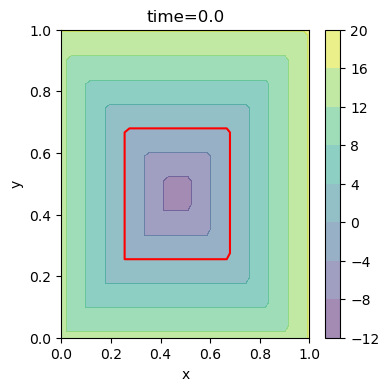

Pseudo-time step 1: Residual norm = 1.6676898220151568
Pseudo-time step 301: Residual norm = 0.005808714229544612
Pseudo-time step 601: Residual norm = 0.00014146178128441854
Pseudo-time step 901: Residual norm = 3.721793311070727e-06


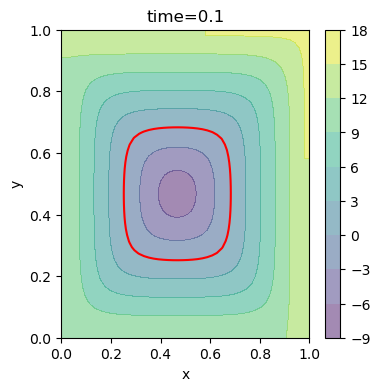

Pseudo-time step 1: Residual norm = 0.4593350297505516
Pseudo-time step 301: Residual norm = 0.006451138344149154
Pseudo-time step 601: Residual norm = 0.00016742902113462473
Pseudo-time step 901: Residual norm = 4.765238563393064e-06


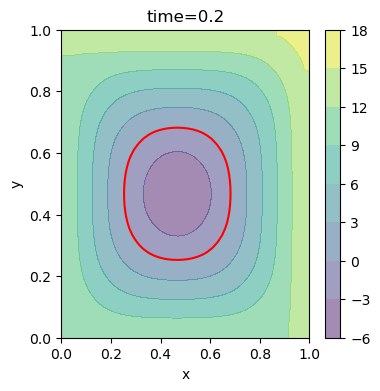

Pseudo-time step 1: Residual norm = 0.31234980075668184
Pseudo-time step 301: Residual norm = 0.006099877496399374
Pseudo-time step 601: Residual norm = 0.00016405127382086346
Pseudo-time step 901: Residual norm = 4.611789351029862e-06


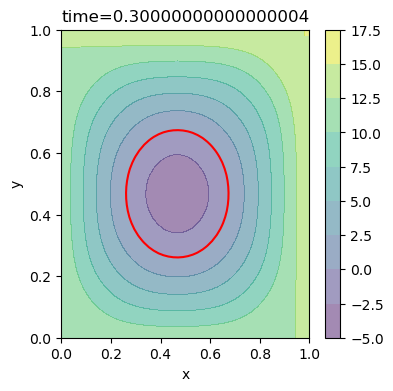

Pseudo-time step 1: Residual norm = 0.24317594546850543
Pseudo-time step 301: Residual norm = 0.005591922995608975
Pseudo-time step 601: Residual norm = 0.00015674768198519962
Pseudo-time step 901: Residual norm = 4.4719417430940594e-06


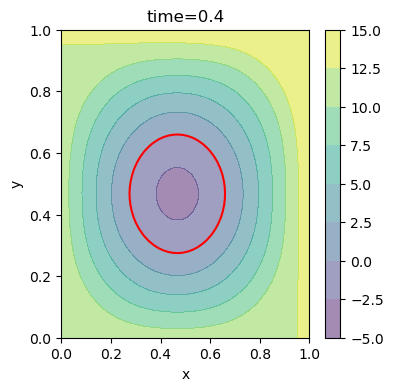

Pseudo-time step 1: Residual norm = 0.20204810965590078
Pseudo-time step 301: Residual norm = 0.005107669177719912
Pseudo-time step 601: Residual norm = 0.00014633701185184347
Pseudo-time step 901: Residual norm = 4.211478076616276e-06


In [ ]:
phi_init = np.zeros((52, 52))  # Initial level set function

spatialsch = SpatialScheme
solver = DualTimeStepping(phi_init, 0.1, 200, spatialsch.Upwind)
solver.solve()
                 